In [ ]:
!pip install kagglehub opencv-python scikit-image matplotlib


In [ ]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download(
    "mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask"
)

print("Dataset path:", path)


100%|██████████| 84.4M/84.4M [00:03<00:00, 23.6MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask/versions/1


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
DATASET_ROOT = os.path.join(path, "data science bowl 2018", "stage1_train 2")

print("Contents of the final DATASET_ROOT:", os.listdir(DATASET_ROOT))

# The following lines are commented out to prevent immediate errors
# IMAGE_PATH = os.path.join(DATASET_ROOT, "images")
# MASK_PATH  = os.path.join(DATASET_ROOT, "masks")
# print("Images found:", len(os.listdir(IMAGE_PATH)))

Contents of the final DATASET_ROOT: ['ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee', '5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed', '3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0', 'fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce93a43f4044eababed5', '2227fd9b01d67c2bcdb407d3205214e6dfeff9fd0725828e3b3651959942ff4a', '1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180', '6c85029f850d392791e13f74963391054ff54e508967bbd091ee510e9e58e011', 'e4ae1ceddb279bac30273ca7ac480025ce2e7287328f5272234b5bbca6d13135', '6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622', 'b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4', '10328b822b836e67b547b4144e0b7eb43747c114ce4cacd8b540648892945b00', '27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47', '10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28', '1023509cf8d4c155467800f89508690be9513431992f470594281cd37dbd020d', '3874755f62

Text(0.5, 1.0, 'Ground Truth')

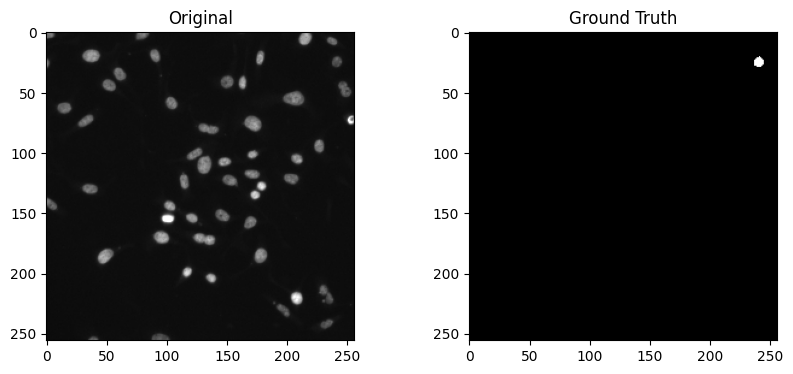

In [ ]:
DATASET_ROOT = os.path.join(path, "data science bowl 2018", "stage1_train 2")

# Get a sample image ID (each directory in DATASET_ROOT is an image ID)
image_id = os.listdir(DATASET_ROOT)[0]

# Construct paths to the image and mask directories for this specific image_id
IMAGE_DIR = os.path.join(DATASET_ROOT, image_id, "images")
MASK_DIR  = os.path.join(DATASET_ROOT, image_id, "masks")

# The image file is typically named after the image_id with a .png extension
image_filename = image_id + ".png"
image_path_full = os.path.join(IMAGE_DIR, image_filename)

# Get the first mask file (there might be multiple masks per image)
mask_filename = os.listdir(MASK_DIR)[0]
mask_path_full = os.path.join(MASK_DIR, mask_filename)

image = cv2.imread(image_path_full)
mask  = cv2.imread(mask_path_full, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

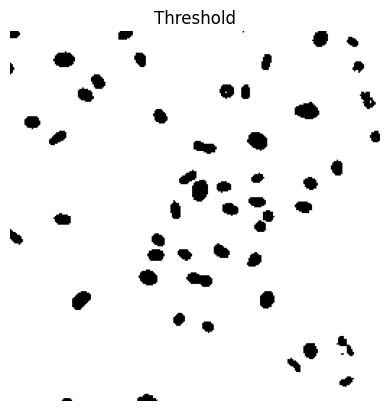

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(thresh, cmap="gray")
plt.title("Threshold")
plt.axis("off")


In [ ]:
kernel = np.ones((3,3), np.uint8)

opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

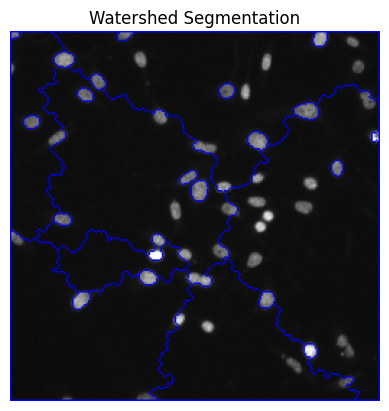

In [ ]:
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(image, markers)

result = image.copy()
result[markers == -1] = [255, 0, 0]

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Watershed Segmentation")
plt.axis("off")


In [ ]:
# Normal watershed (no marker control)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Simple threshold
_, thresh_simple = cv2.threshold(gray, 0, 255,
                                 cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Connected components directly
_, markers_simple = cv2.connectedComponents(thresh_simple)

markers_simple = markers_simple + 1
markers_simple = cv2.watershed(image, markers_simple)

no_marker_result = image.copy()
no_marker_result[markers_simple == -1] = [255, 0, 0]


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

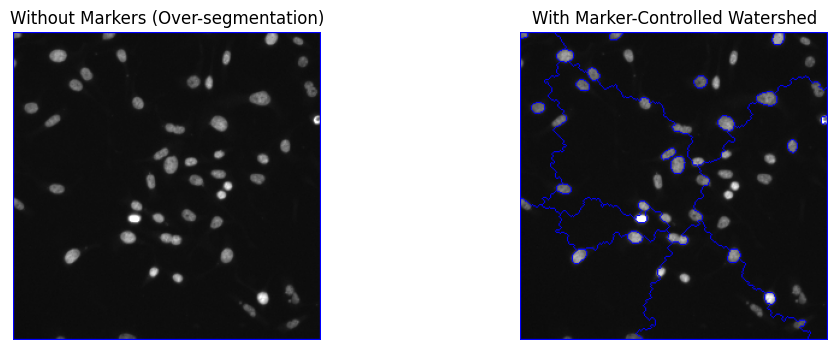

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(no_marker_result, cv2.COLOR_BGR2RGB))
plt.title("Without Markers (Over-segmentation)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("With Marker-Controlled Watershed")
plt.axis("off")


Text(0.5, 1.0, 'Regions With Markers')

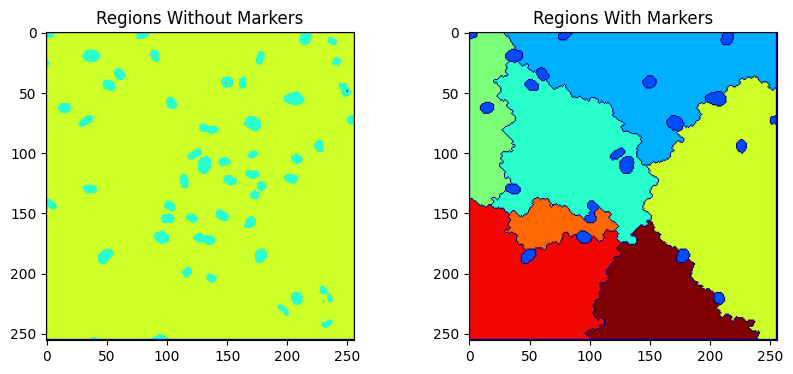

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(markers_simple, cmap="jet")
plt.title("Regions Without Markers")

plt.subplot(1,2,2)
plt.imshow(markers, cmap="jet")
plt.title("Regions With Markers")


Conclusion — Cell Nuclei Separation (Watershed)

In this experiment, watershed segmentation was applied to separate touching nuclei from microscopy images of the Data Science Bowl dataset. The initial thresholding step successfully detected most nuclei regions, but when watershed was applied without markers, the segmentation produced large irregular regions and clear over-segmentation, as seen from excessive boundaries across the image.

After introducing marker-controlled watershed, the segmentation improved by using foreground and background markers to guide region separation. This reduced unnecessary splitting and produced clearer boundaries around individual nuclei. The region visualization also showed that marker-based watershed created more meaningful segmentation compared to the uncontrolled version.

However, comparison with the ground truth mask indicated that segmentation accuracy still depends on marker quality. Some nuclei were merged or partially segmented, highlighting the importance of proper preprocessing and marker generation.

Final Result: Marker-controlled watershed performed better than normal watershed by reducing over-segmentation and providing more accurate separation of touching nuclei, demonstrating its effectiveness for biomedical image segmentation tasks.